# Dask Array

Материалы:
* Макрушин С.В. Лекция 11: Dask
* https://docs.dask.org/en/latest/array.html
* JESSE C. DANIEL. Data Science with Python and Dask. 

## Задачи для совместного разбора

1. Создайте массив размерностью 1000 на 300000, заполненный числами из стандартного нормального распределения. Исследуйте основные характеристики полученного массива.

2. Посчитайте сумму квадратов элементов массива, созданного в задаче 1. Создайте массив `np.array` такого же размера и сравните скорость решения задачи с использование `da.array` и `np.array`

3. Визуализируйте граф вычислений для задачи 2.

## Лабораторная работа 11

In [1]:
import dask

In [2]:
dask.__version__

'2021.12.0'

In [3]:
import dask.array as da
import h5py
import numpy as np
import pandas

In [3]:
pandas.DataFrame(h5py.File('minutes_n_ingredients_full.hdf5', 'r')['recipe'])

,0,1,2
0,683970,33,9
1,1089012,23,5
2,1428572,0,5
3,1400250,24,1
4,387709,47,10
...,...,...,...
2231632,1029131,19,4
2231633,1700703,1,1
2231634,1910650,60,2
2231635,713836,0,9


1. Считайте датасет `recipe` из файла `minutes_n_ingredients_full.hdf5` в виде `dask.array`. Укажите аргумент `chunks=(100_000, 3)` при создании массива. Выведите на экран основную информацию о массиве.

In [4]:
da_data = da.from_array(h5py.File('minutes_n_ingredients_full.hdf5', 'r')['recipe'], chunks=(100_000, 3))
da_data

dask.array<array, shape=(2231637, 3), dtype=int64, chunksize=(100000, 3), chunktype=numpy.ndarray>

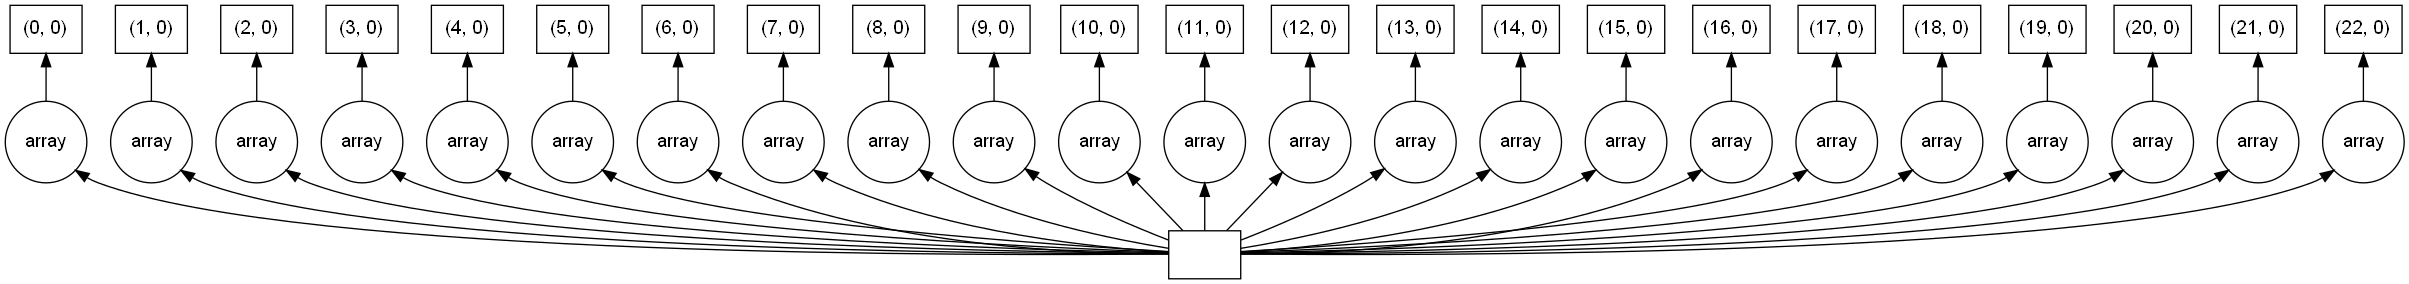

In [5]:
da_data.visualize()

2. Вычислите среднее значение по каждому столбцу, кроме первого. 

In [6]:
%%time
da_mean = da_data[:, 1:].mean(axis=0).compute()
da_mean

Wall time: 85 ms


array([1004.20805176,    5.4198008 ])

3. Исследуйте, как влияет значение аргумента `chunks` при создании `dask.array` на скорость выполнения операции поиска среднего. 

In [7]:
%%time
da_data1 = da.from_array(h5py.File('minutes_n_ingredients_full.hdf5', 'r')['recipe'], chunks=(10_000, 3))
da_mean1 = da_data1[:, 1:].mean(axis=0).compute()
da_mean1

Wall time: 283 ms


array([1004.20805176,    5.4198008 ])

In [8]:
%%time
da_data1 = da.from_array(h5py.File('minutes_n_ingredients_full.hdf5', 'r')['recipe'], chunks=(1_000, 3))
da_mean1 = da_data1[:, 1:].mean(axis=0).compute()
da_mean1

Wall time: 2.02 s


array([1004.20805176,    5.4198008 ])

In [9]:
%%time
da_data1 = da.from_array(h5py.File('minutes_n_ingredients_full.hdf5', 'r')['recipe'], chunks=(1_000_000, 3))
da_mean1 = da_data1[:, 1:].mean(axis=0).compute()
da_mean1

Wall time: 74 ms


array([1004.20805176,    5.4198008 ])

In [10]:
%%time
da_data1 = da.from_array(h5py.File('minutes_n_ingredients_full.hdf5', 'r')['recipe'], chunks=(2_000_000, 3))
da_mean1 = da_data1[:, 1:].mean(axis=0).compute()
da_mean1

Wall time: 97 ms


array([1004.20805176,    5.4198008 ])

4. Выберите рецепты, время выполнения которых меньше медианного значения

In [11]:
da_data[da_data[1] < da_data[1].median(axis=0)]

AttributeError: 'Array' object has no attribute 'median'

5. Посчитайте количество каждого из возможных значений кол-ва ингредиентов

In [12]:
unique, counts = da_data.unique(recipes[:, 2], return_counts=True)

AttributeError: 'Array' object has no attribute 'unique'

6. Найдите максимальную продолжительность рецепта. Ограничьте максимальную продолжительность рецептов сверху значением, равному 75% квантилю.

7. Создайте массив `dask.array` из 2 чисел, содержащих ваши предпочтения относительно времени выполнения рецепта и кол-ва ингредиентов. Найдите наиболее похожий (в смысле $L_1$) рецепт из имеющихся в датасете.

8. Работая с исходным файлом в формате `hdf5`, реализуйте алгоритм подсчета среднего значения в блочной форме и вычислите с его помощью среднее значение второго столбца в массиве.

Блочный алгоритм вычислений состоит из двух частей:
1. загрузка фрагмента за фрагментом данных по `blocksize` элементов и проведение вычислений на этим фрагментом;
2. агрегация результатов вычислений на различных фрагментах для получения результата на уровне всего набора данных.

Важно: при работе с `h5py` в память загружаются не все элементы, а только те, которые запрашиваются в данный момент